Test notebook


In [2]:
# %%

import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np



In [3]:

''' Format plots'''

fsize = 11
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']) 



Import the data from the runs 

In [9]:
# all_strike_prices = np.load(f'C:/Users/LukaK/OneDrive - Durham University/Projects/Agent based modelling easy/PowerSim/data_out/all_strike_prices.npy')
# total_per_tech = np.load(f'C:/Users/LukaK/OneDrive - Durham University/Projects/Agent based modelling easy/PowerSim/data_out/total_per_tech.npy')

import os

directory = 'data/total_per_tech/3moneyalmostworking/tech/'

npy_files = [filename for filename in os.listdir(directory) if filename.endswith('.npy')]

# Load the first file to initialize the array


arrays =[]
# stack the remaining files
for filename in npy_files[1:]:
    filepath = os.path.join(directory, filename)
    file_data = np.load(filepath)
    arrays.append(file_data)

total_per_tech = np.stack(arrays, axis =0)
'''[run, year, tech, hour]'''


print(np.shape(total_per_tech))



''' set the number parameters from the run'''
n_days = 24
n_years = 30


descriptor  = '3rd money working 2 percent tax'
tech_types = ['nuclear', 'coal', 'fossil_fuel', 'bioenergy', 'wind_onshore', 'wind_offshore', 'solar', 'hydro', 'CCGT']


(499, 30, 9, 576)


0.0011891080925906276 0.9788560863166272


change data 

In [10]:

from scipy.stats import norm

x = range(1, n_years+1)
data = np.mean(total_per_tech, axis = 3)  # 10 sets of 100 data points

print(np.shape(data))

# Generate some sample data


# Loop through each of the 5 sets of data
mean_all = []
stdev_all = []
for j in range(data.shape[2]):
    means = []
    stdev = []
    # Loop through each of the 10 sets of data within the current set
    for i in range(data.shape[1]):
        y = data[:, i, j]
        mu, std = norm.fit(y)
        means.append(mu)
        stdev.append(std)
    # Calculate the average parameters and errors for the current set
   
    # Add the average parameters and errors to the list for all sets
    mean_all.append(means)
    stdev_all.append(stdev)

mean_all = np.array(mean_all)
stdev_all = np.array(stdev_all)
# Calculate the average parameters and errors for all sets

# Print the results
print(mean_all)
mean_all.shape

(499, 30, 9)
[[6.17872366e+03 6.17872366e+03 6.17872366e+03 6.17872366e+03
  6.17872366e+03 6.17872366e+03 6.17872366e+03 6.17855825e+03
  6.17811658e+03 6.17762469e+03 6.17700623e+03 6.17633638e+03
  6.17570683e+03 6.33994166e+03 6.46335822e+03 6.56486206e+03
  6.64665644e+03 6.69530081e+03 6.73978897e+03 6.79076682e+03
  6.81926234e+03 6.83851170e+03 6.85020079e+03 6.86957638e+03
  6.88019541e+03 6.02117583e+03 6.02276179e+03 6.03053599e+03
  6.03083039e+03 6.03199480e+03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.04461716e+00 8.52073017e+00
  2.98271131e+01 4.72455254e+01 1.00061836e+02 1.11960229e+02
  1.40640732e+02 1.54896633e+02 2.18666914e+02 2.28570546e+02
  2.32900285e+02 2.47541863e+02 2.50124561e+02 2.74408507e+02
  3.61814006e+02 4.26537448e+02 4.88911552e+02 5.81941931e+02
  5.89708664e+02 5.97930665e+02]
 [4.03342450e+00 3.86042125e+00 3.81957647e+00 3.6658

(9, 30)

Make the graphs

(499, 30, 9, 576)
(9, 576)


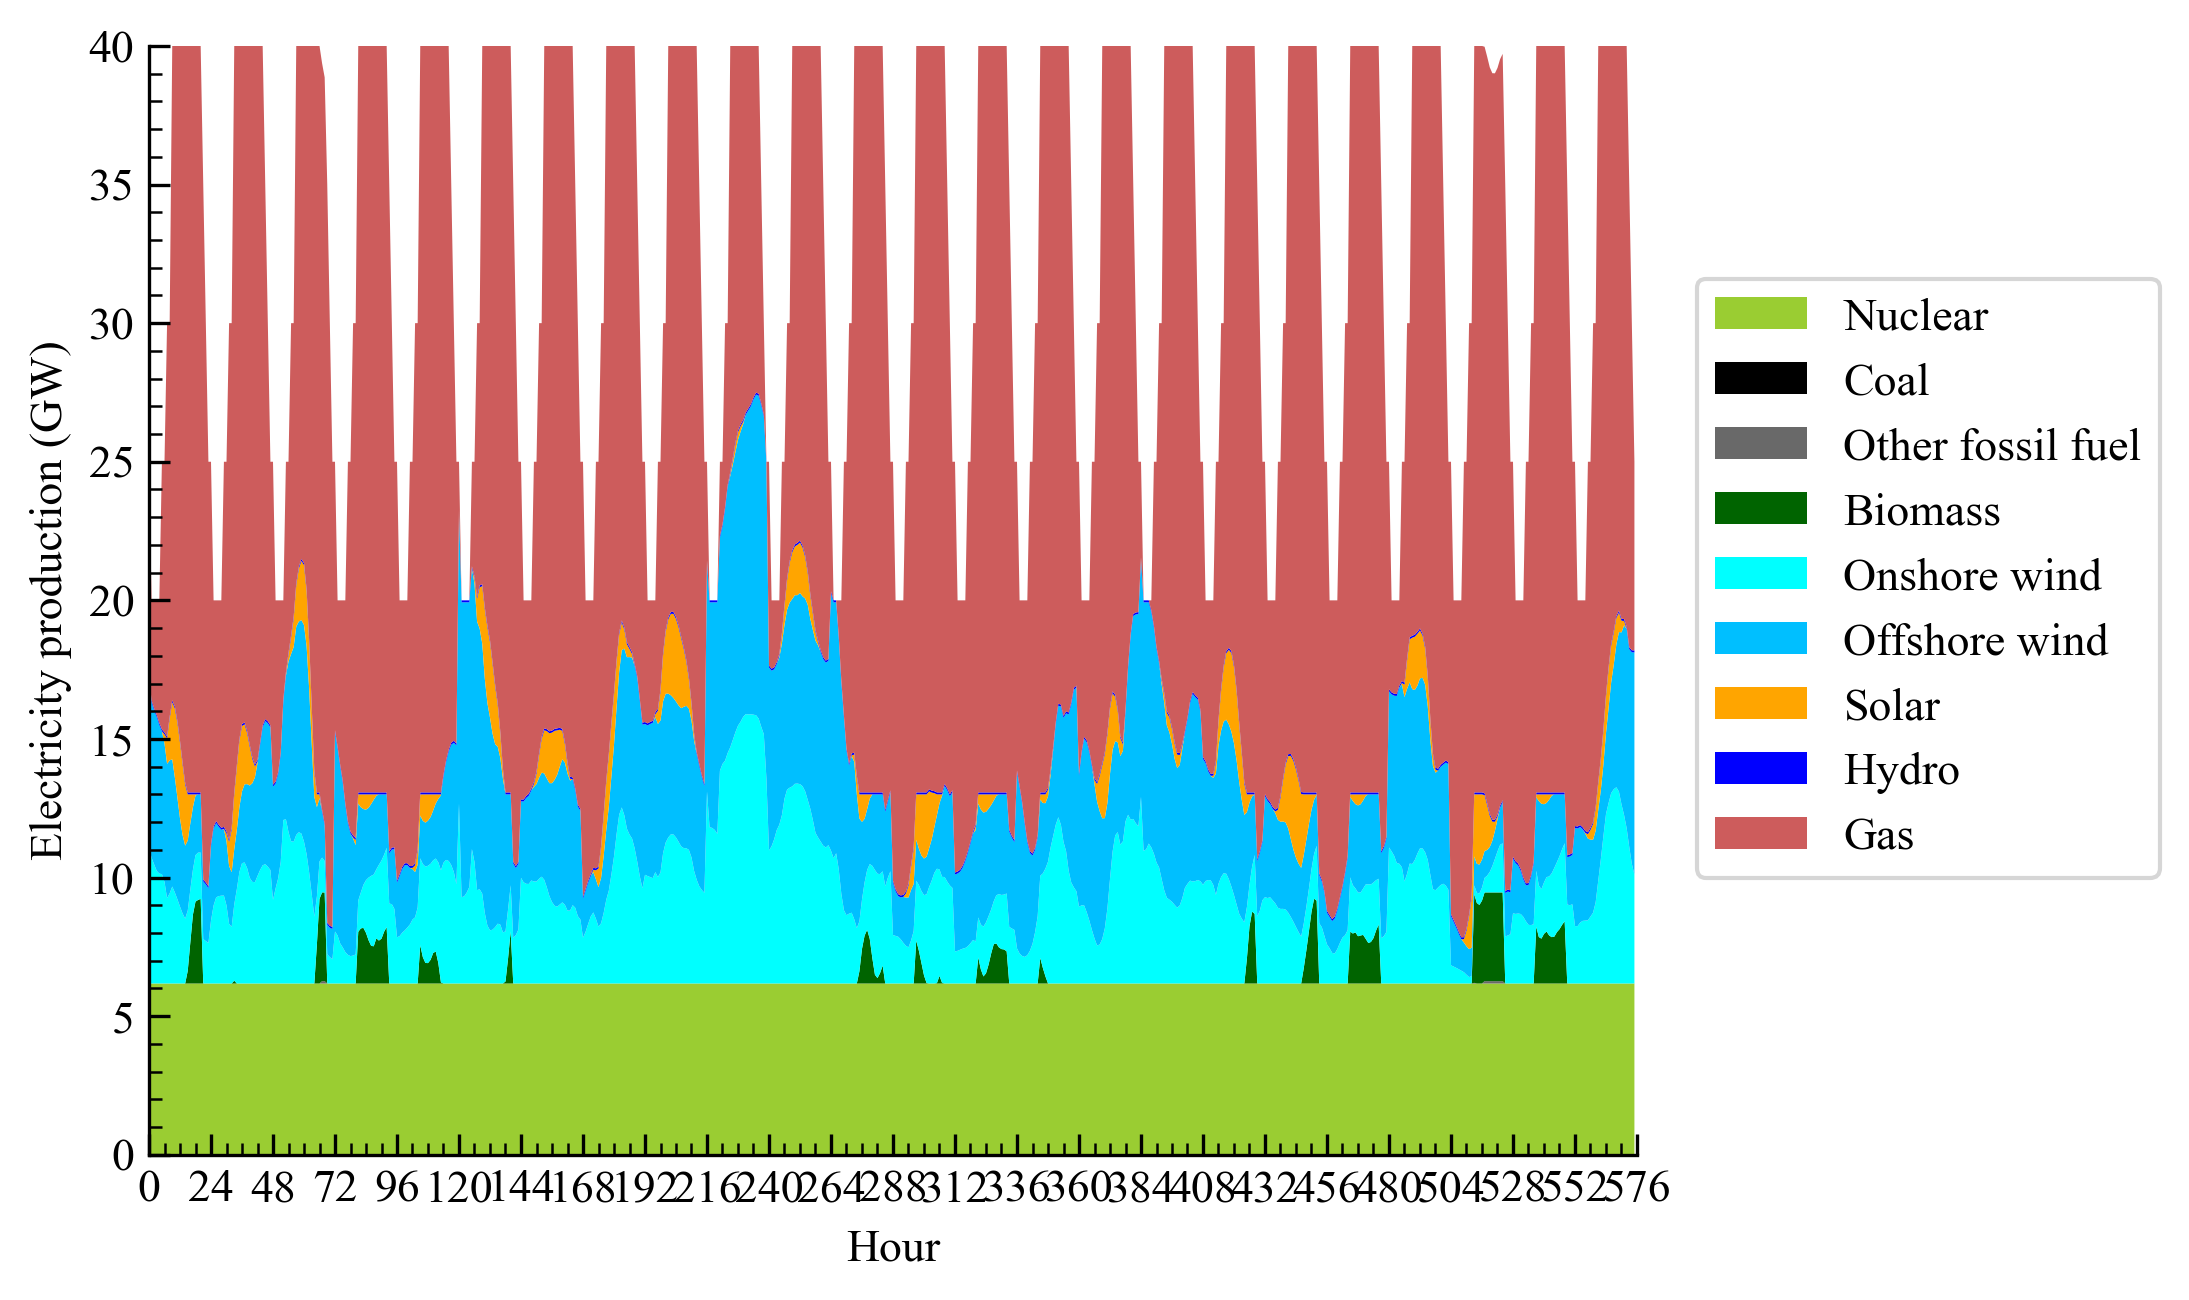

In [12]:


#%%
'''Stacked plot of daily production'''

fig, ax = plt.subplots()


print(np.shape(total_per_tech))



ydata = total_per_tech[0,0,:,:]/1000

print(np.shape(ydata))

xdata = range((n_days*24))

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']) 

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']
ax.stackplot(xdata,*ydata, labels = [t for t in tech_types_named])
#have to remove the historical data from the plot



ax.set_ylabel('Electricity production (GW)')
ax.set_xlabel('Hour')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xlim(0, len(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

#plt.savefig(fname = f'{descriptor}year production by day', bbox_inches = "tight" )
plt.show()



(30, 9)


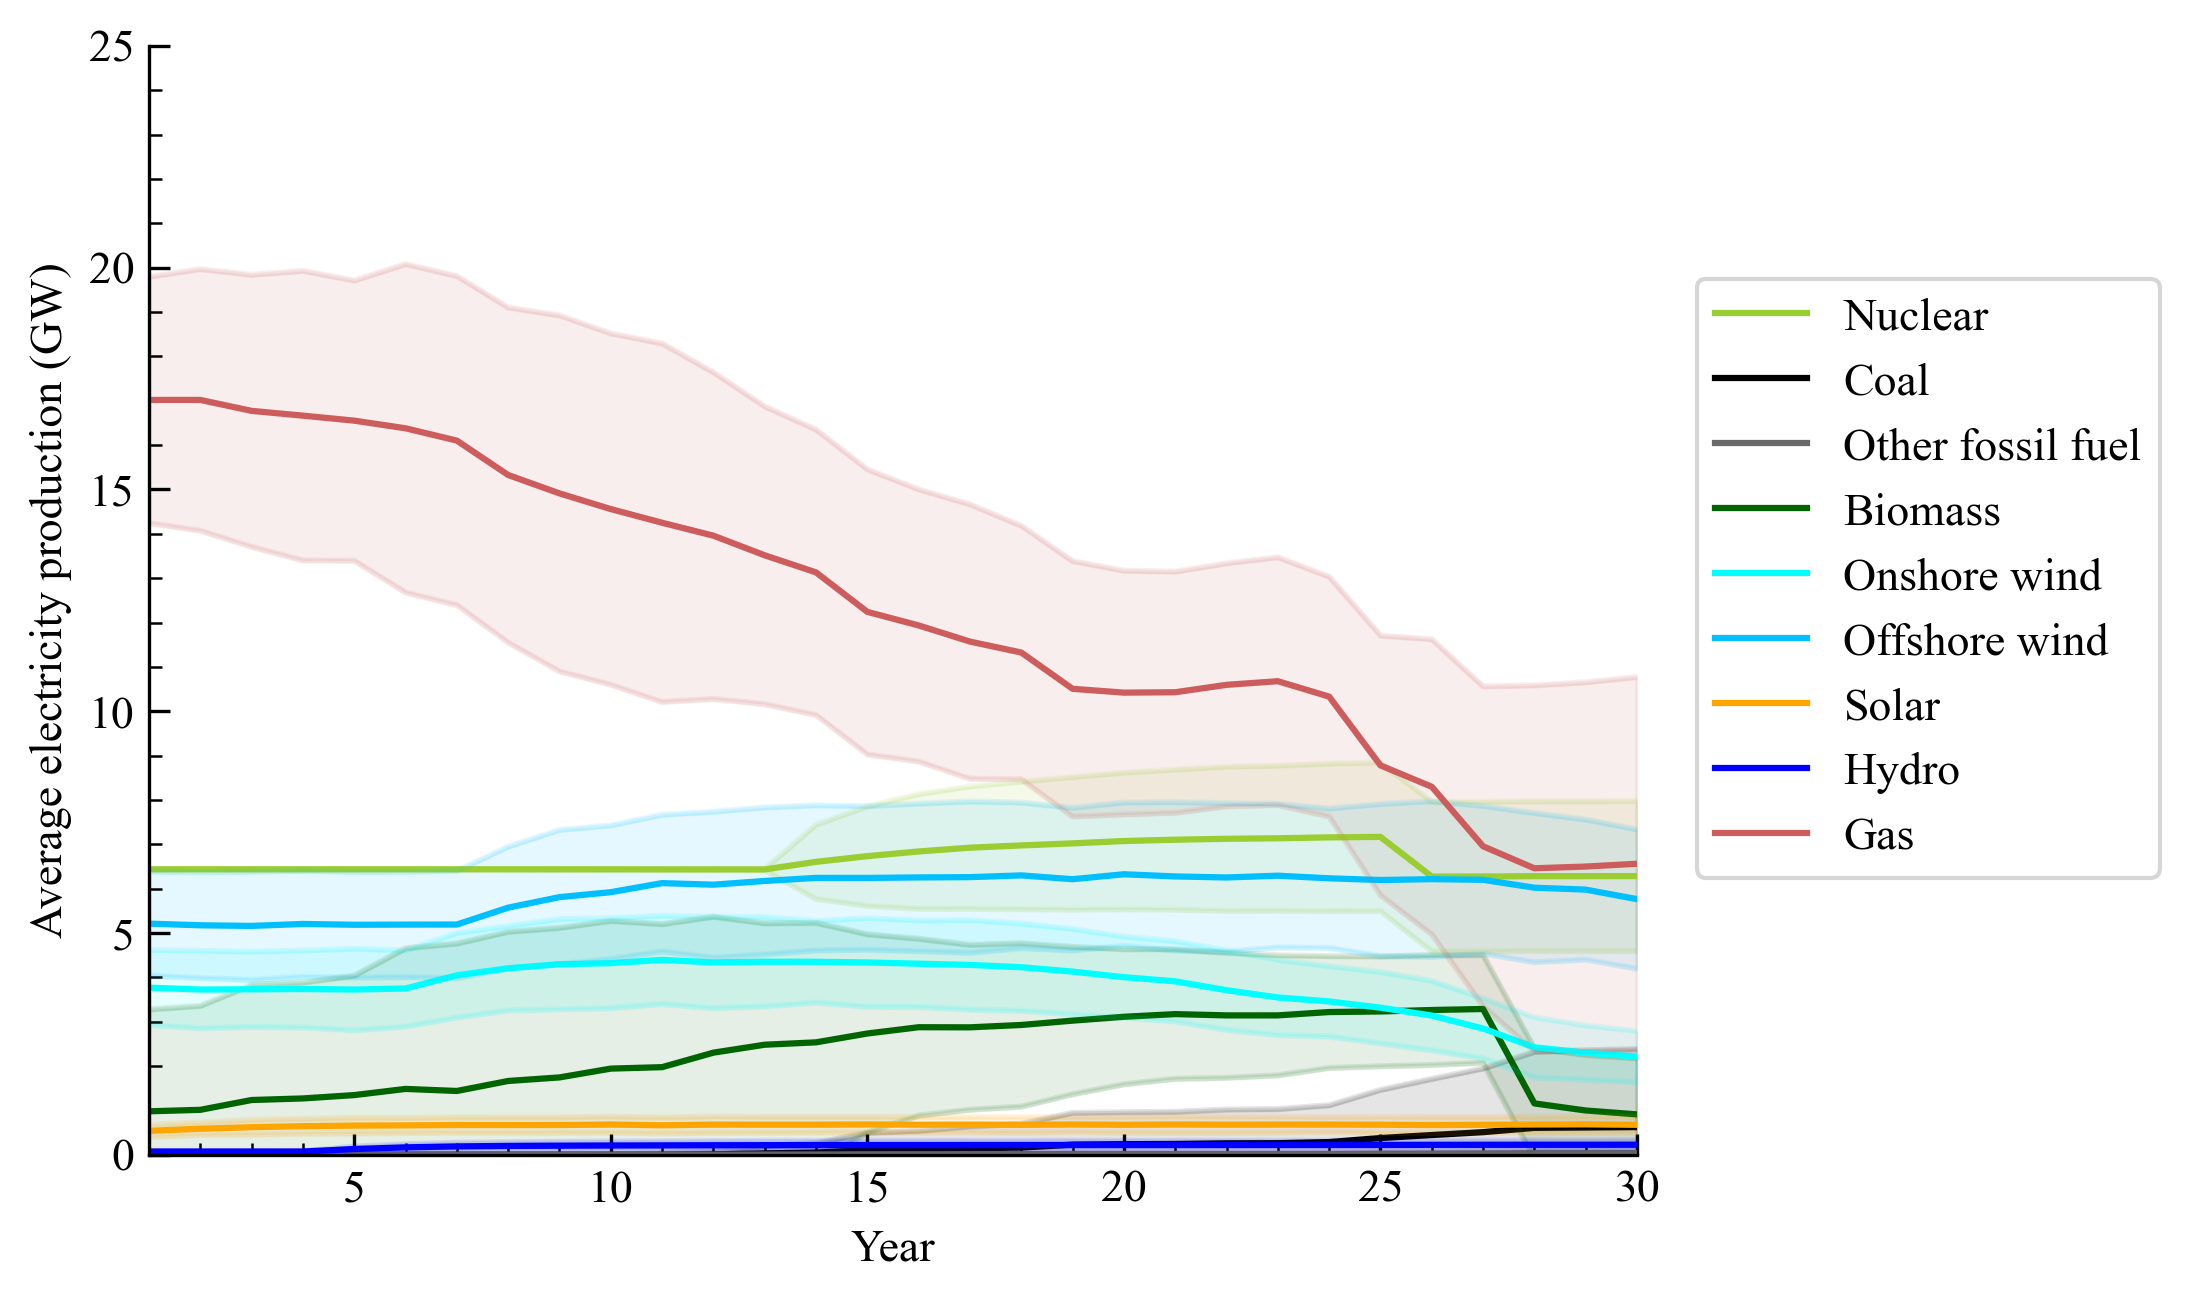

In [13]:


fig, ax = plt.subplots()

total_per_tech_average= np.mean(total_per_tech, axis=3)

ydata = np.mean(total_per_tech_average, axis = 0)
print(np.shape(ydata))
xdata = range(1, n_years+1)

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']
colours = ["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']
for i in range(9):
    y = ydata[:,i]/(960)
    ax.plot(xdata,y, label =  tech_types_named[i], color = colours[i])
    ax.plot(xdata, (mean_all[i,:] + 2*stdev_all[i, :])/960, color = colours[i], alpha = 0.1)
    ax.plot(xdata, (mean_all[i,:] - 2*stdev_all[i, :])/960, color = colours[i], alpha = 0.1)
    ax.fill_between(xdata, (mean_all[i,:] + 2*stdev_all[i, :])/960, (mean_all[i,:] - 2*stdev_all[i, :])/960,color = colours[i], alpha = 0.1)
#have to remove the historical data from the plot

ax.set_ylabel('Average electricity production (GW)')
ax.set_xlabel('Year')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, max(xdata))
ax.set_ylim(0)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}average_production yearly', bbox_inches = "tight" )
plt.show()




In [15]:

'''Get average yearly prices'''

directory = 'data/total_per_tech/3moneyalmostworking/price/'

npy_files = [filename for filename in os.listdir(directory) if filename.endswith('.npy')]

# Load the first file to initialize the array


arrays =[]
# stack the remaining files
for filename in npy_files[1:]:
    filepath = os.path.join(directory, filename)
    file_data = np.load(filepath)
    arrays.append(file_data)

yearly_price = np.stack(arrays, axis =0)
'''[run, year, tech, hour]'''



'[run, year, tech, hour]'

In [16]:
n_days = 24
n_runs = 499
print(np.shape(yearly_price))



average_daily_p = np.mean(yearly_price, axis = 2)

av_daily_2d = average_daily_p.reshape(n_runs,n_years,n_days)
print(np.shape(av_daily_2d))

mean_yearly = np.mean(av_daily_2d, axis = 2)





x = range(1, n_years+1)
data = mean_yearly  # 10 sets of 100 data points

print(np.shape(data))

# Generate some sample data


# Loop through each of the 5 sets of data
mean_all_price = []
stdev_all_price = []

for i in range(data.shape[1]):
    y = data[:, i]
    mu, std = norm.fit(y)
    mean_all_price.append(mu)
    stdev_all_price.append(std)
# Calculate the average parameters and errors for the current set

# Add the average parameters and errors to the list for all sets


mean_all_price = np.array(mean_all_price)
stdev_all_price = np.array(stdev_all_price)
# Calculate the average parameters and errors for all sets

# Print the results
print(mean_all_price)
print(stdev_all_price)
mean_all.shape


(499, 720, 24)
(499, 30, 24)
(499, 30)
[ 86.54414812  87.12770761  88.78003962  89.60872671  89.91163092
  88.65395271  87.97667471  88.72420744  88.78808238  90.11209666
  90.66149555  94.73589489 100.18871157 102.19337404 111.34679846
 114.0206878  117.94075699 120.65322249 129.34887725 131.51927224
 133.76285871 136.94003732 139.28141658 144.98061605 157.6455356
 170.69655627 181.35336293 198.50292547 202.05758762 206.20856235]
[ 9.42859582  9.33970112 10.16693241  9.27056107  9.34753909 10.37284355
 10.60444227 10.73664202 10.35585813 10.03186245 10.50847016 10.47499764
 11.34794975 11.30400356 10.57626837 10.91989716 11.57718697 11.76032603
 11.21977174 11.15106243 11.27112082 11.79672624 11.06511304 11.6194681
 11.55970939 12.0564697  11.4661719   9.84216233  9.88597996  9.9474984 ]


(9, 30)

No handles with labels found to put in legend.


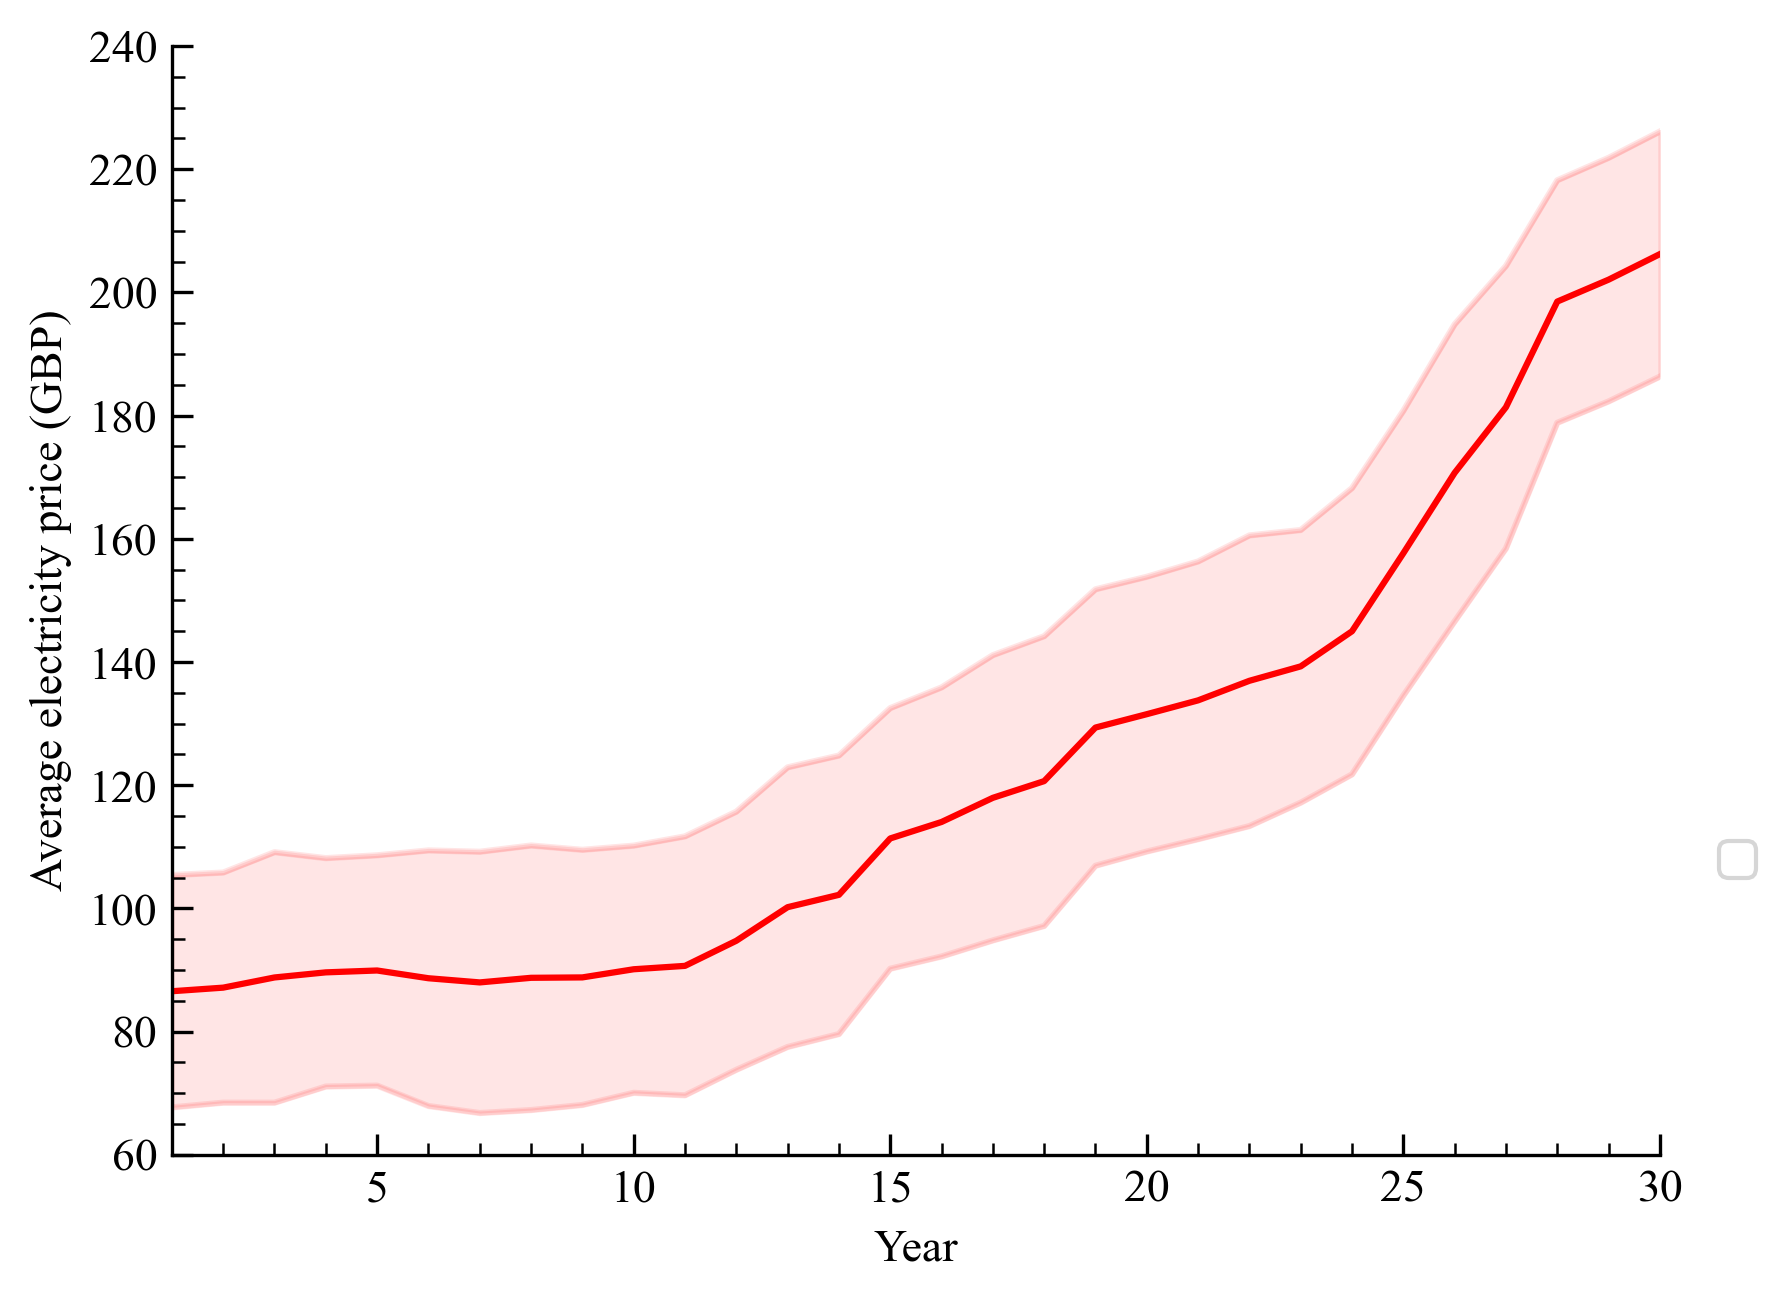

In [17]:

fig, ax = plt.subplots()


ydata = mean_all_price

xdata = range(1, n_years+1)

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']

ax.plot(xdata,ydata, color = 'r')
ax.plot(xdata, ydata + 2*stdev_all_price, color = 'r', alpha = 0.1)
ax.plot(xdata, ydata - 2*stdev_all_price, color = 'r', alpha = 0.1)
ax.fill_between(xdata, ydata + 2*stdev_all_price, ydata - 2*stdev_all_price, color ='r', alpha = 0.1 )
#have to remove the historical data from the plot

ax.set_ylabel('Average electricity price (GBP)')
ax.set_xlabel('Year')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, max(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}av. price.png', bbox_inches = "tight" )
plt.show()


In [41]:
import electricity_company
import pickle

with open('powerplants.pickle', 'rb') as f:
    obj_list_new = pickle.load(f)


In [57]:


tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']

for obj in obj_list_new: 
    if obj.name == 'RWE Npower':
        elec_co = obj

plant_list_npower = elec_co.power_plants

for plant in plant_list:
    print(plant.capacity_MW)

        for tech in tech_types:
        energy = [(plant.energy_supplied_per_hour[-(24*world.n_days):]) for plant in plant_list if plant.technology == tech and len(plant.energy_supplied_per_hour) >= 24]
        energy = np.sum(energy, axis = 0)
        y_total_per_tech.append(energy)

0.505
0.505
0.56
0.6
0.75
0.78
0.85
0.95
1.35
2.0
2.0
2.274
2.3
2.3
2.3
2.4
2.5
2.6
2.75
2.75
2.969
3.0
3.0
3.5
3.9
4.0
4.1
4.1
5.0
5.15
5.15
5.5
6.0
6.0
6.0
6.6
9.0
9.1
9.2
9.4
9.4
9.6
9.9
14.0
14.98
15.6
15.6
15.8
16.0
17.0
17.0
19.3
20.0
20.0
20.5
24.7
26.65
32.8
33.0
34.85
36.8
40.0
44.0
44.0
50.0
54.0
55.0
57.4
59.8
60.0
60.0
65.0
84.0
90.0
90.0
96.0
100.0
140.0
219.0
352.8
395.0
400.2
420.0
576.0
630.0
723.0
857.0
1450.0
1772.0
2199.0
5.39904
1.21275
7.63
5.41057
4.857
18.73872
0.054
9.6
9.9
1.51164
2.9
119.8
0.958
0.8064
94.05
20.5
4.6
7.2
